## Black-box Vector Optimization on Fairness
This notebook contains a vector optimization example on an ML fairness dataset, and compares Naive Elimination and PaVeBa algorithms.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import vopy.algorithms
from vopy.utils import set_seed
from vopy.order import ConeTheta2DOrder
from vopy.datasets import get_dataset_instance
from vopy.utils.evaluate import calculate_epsilonF1_score

Let's first create an `Order` object to define our preference and visualize it's cone.

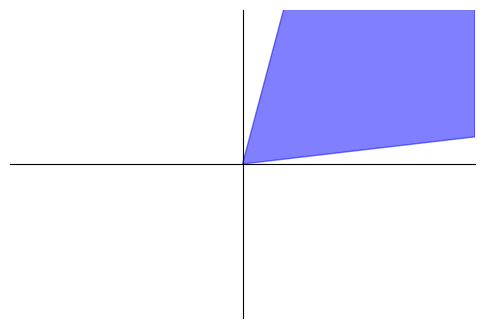

In [2]:
order = ConeTheta2DOrder(cone_degree=70)
fig_cone = order.ordering_cone.plot()

Now, we will create an instance of ML fairness dataset and visualize its Pareto front w.r.t. the order we created.

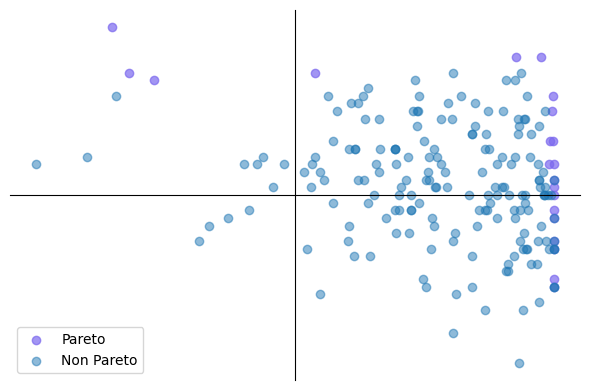

In [3]:
dataset_name = "Fairness"
dataset = get_dataset_instance(dataset_name)
fig_pareto = order.plot_pareto_set(dataset.out_data)

We'll now run both algorithms and print the results.

In [4]:
epsilon = 0.01
delta = 0.05
noise_var = epsilon

alg_names = ["NaiveElimination", "PaVeBa"]
alg_params = {
    "NaiveElimination": {"L": 10},
    "PaVeBa": {"conf_contraction": 16}
}

for alg_name in alg_names:
    set_seed(0)

    algorithm = getattr(vopy.algorithms, alg_name)(
        epsilon=epsilon, delta=delta,
        dataset_name=dataset_name, order=order, noise_var=noise_var, **alg_params[alg_name]
    )

    while True:
        is_done = algorithm.run_one_step()

        if is_done:
            break

    pred_pareto_indices = sorted(list(algorithm.P))
    pareto_indices = order.get_pareto_set(dataset.out_data)

    eps_f1 = calculate_epsilonF1_score(
        dataset, order, pareto_indices, pred_pareto_indices, epsilon
    )
    print(f"{alg_name} - epsilon-F1 Score: {eps_f1:.2f}")
    print(f"{alg_name} - Number of observations: {algorithm.sample_count}")

NaiveElimination - epsilon-F1 Score: 0.93
NaiveElimination - Number of observations: 2000
PaVeBa - epsilon-F1 Score: 0.95
PaVeBa - Number of observations: 453
